In [ ]:
!wget https://hf.co/danjacobellis/walloc/resolve/main/v0.6.3_ext.pth

In [34]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from PIL import Image
from IPython.display import display
from torchvision.transforms import ToPILImage, PILToTensor, Resize, CenterCrop, ToTensor
from walloc import walloc
from piq import LPIPS
class Args: pass

In [2]:
device = "cuda:0"
checkpoint = torch.load("v0.6.3_ext.pth",map_location="cpu")
args = checkpoint['args']
codec = walloc.Walloc(
    channels = args.channels,
    J = args.J,
    N = args.N,
    latent_dim = args.latent_dim,
    latent_bits = 5
)
codec.load_state_dict(checkpoint['model_state_dict'])
codec = codec.to(device)
codec.eval();

In [4]:
inet1k = load_dataset("imagenet-1k")

Loading dataset shards:   0%|          | 0/257 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/25 [00:00<?, ?it/s]

In [48]:
lpips_loss = LPIPS().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
%%time
lanczos = Image.Resampling.LANCZOS
lpips_224 = []
lpips_walloc = []
for i_sample, sample in enumerate(inet1k['validation']):
    img = sample['image'].convert("RGB")
    img = CenterCrop(min(img.width,img.height))(img)
    img_224 = Resize(img.width)((Resize(224,lanczos)(img)))
    with torch.no_grad():
        x = PILToTensor()(Resize(512)(img)).to(torch.float)
        x = (x/255 - 0.5).unsqueeze(0).to(device)
        x_hat, _, _ = codec(x)
        img_walloc = ToPILImage()(x_hat[0]+0.5)
        img_walloc = Resize(img.width)(img_walloc)
        
        lpips_224.append(lpips_loss(
            ToTensor()(img).unsqueeze(0).to(device),
            ToTensor()(img_224).unsqueeze(0).to(device),
        ).item())
        lpips_walloc.append(lpips_loss(
            ToTensor()(img).unsqueeze(0).to(device),
            ToTensor()(img_walloc).unsqueeze(0).to(device),
        ).item())

CPU times: user 2d 15h 20min 31s, sys: 15min 17s, total: 2d 15h 35min 49s
Wall time: 1h 6min 55s


In [63]:
np.median([-10*np.log10(d) for d in lpips_224])

/tmp/ipykernel_1020559/4194406233.py:1: RuntimeWarning: divide by zero encountered in log10
  np.median([-10*np.log10(d) for d in lpips_224])


7.9270323079281715

In [64]:
np.median([-10*np.log10(d) for d in lpips_walloc])

8.172087484982198

In [69]:
-10*np.log10(lpips_224[-1])

6.705433951066365

In [70]:
-10*np.log10(lpips_walloc[-1])

6.3595242381397386

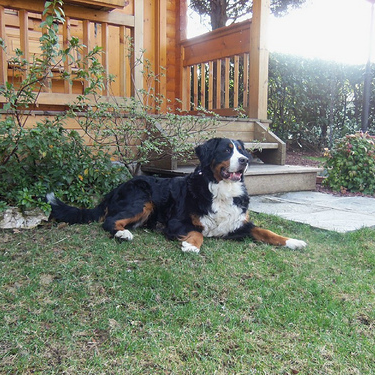

In [65]:
img

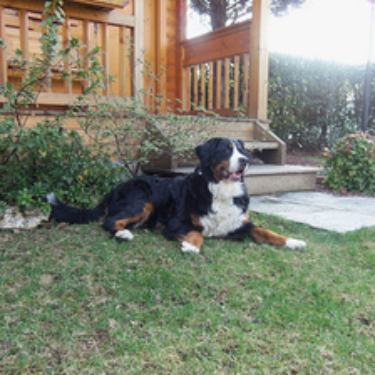

In [66]:
img_224

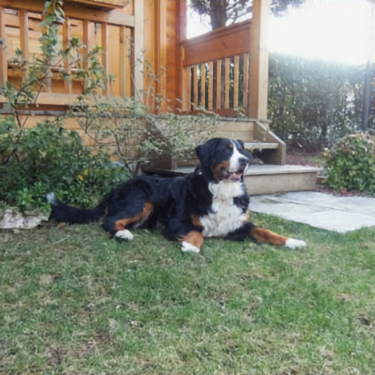

In [67]:
img_walloc